# Object detection demo
This notebook shows an example of object detection of an image.
The network that is used for inference is a variant of Tiny-Yolo, whose topology is illustrated in the following picture.
The pynq colored layers have been quantized with 1 bit for weights and 3 bit for activations, and will be executed in the HW accelerator, while the other layers are executed in python.

The image processing is performed within darknet by using python bindings.


![TinierYolo topology](Tinier-YOLO-topology.svg)

In [8]:
import sys
import os, platform
import json
import numpy as np
import cv2
import ctypes
from PIL import Image
from datetime import datetime
import random
import io
import base64

import qnn
from qnn import TinierYolo
from qnn import utils 
sys.path.append("/opt/darknet/python/")
from darknet import *

from matplotlib import pyplot as plt
from IPython.display import display, HTML
%matplotlib inline


## 1. Instantiate a Classifier
Creating a classifier will automatically download the bitstream onto the device. All other initializations are currently performed in the Darknet framework. 

In [9]:
# --- Initialization ---
classifier = TinierYolo()
classifier.init_accelerator()
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-layers.json")

conv0_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-W.npy', encoding="latin1", allow_pickle=True)
conv0_weights_correct = np.transpose(conv0_weights, axes=(3, 2, 1, 0))
conv8_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-W.npy', encoding="latin1", allow_pickle=True)
conv8_weights_correct = np.transpose(conv8_weights, axes=(3, 2, 1, 0))
conv0_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-bias.npy', encoding="latin1", allow_pickle=True)
conv0_bias_broadcast = np.broadcast_to(conv0_bias[:,np.newaxis], (net['conv1']['input'][0],net['conv1']['input'][1]*net['conv1']['input'][1]))
conv8_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-bias.npy', encoding="latin1", allow_pickle=True)
conv8_bias_broadcast = np.broadcast_to(conv8_bias[:,np.newaxis], (125,13*13))
file_name_cfg = c_char_p("/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-bwn-3bit-relu-nomaxpool.cfg".encode())
net_darknet = lib.parse_network_cfg(file_name_cfg)


## 2. Get object detection from input image


The image to be run through object detection is loaded automatically from the path set in the *img_folder* variable. The original image is shown before processing and will be automatically selected as the last one downloaded (both variables *img_folder* and *image_name* can be modified to the desired path/image to be classified). 

The neural network has been trained on the [PASCAL VOC (Visual Object Classes)](http://host.robots.ox.ac.uk/pascal/VOC/) and is able to identify 20 classes of objects in an image, namely: 
* Person: person
* Animal: bird, cat, cow, dog, horse, sheep
* Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
* Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

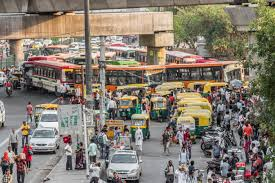

In [10]:
img_folder = './yolo_test_images/'
img_file = os.path.join(img_folder, random.choice(os.listdir(img_folder)))
file_name = c_char_p(img_file.encode())

img = load_image(file_name,0,0)
img_letterbox = letterbox_image(img,416,416)
img_copy = np.copy(np.ctypeslib.as_array(img_letterbox.data, (3,416,416)))
img_copy = np.swapaxes(img_copy, 0,2)
free_image(img)
free_image(img_letterbox)

im = Image.open(img_file)
im

## 3. Execute the first convolutional layer in Python

The first layer of this neural network has not been quantized, thus will not be executed in the HW accelerator (which supports only quantized arithmetic). Python provides, with numpy, a backend to execute convolution and other matrix operations. For user convenience the most popular operations (convolutional layer, thresholding, relu and fully connected layer) are provided in the utils class.

In [11]:
def display_images_html(results, max_width=300, max_height=300, cols=3):
    """Generate HTML table to display images with captions directly in Jupyter"""
    html = "<table style='border-collapse: collapse; border: none;'>"
    n = len(results)
    rows = (n + cols - 1) // cols
    for r in range(rows):
        html += "<tr style='border: none;'>"
        for c in range(cols):
            idx = r * cols + c
            if idx < n:
                img_name, result = results[idx]
                top_class = result['detections'][0][1] if result['detections'] else "None"
                top_prob = result['detections'][0][0] if result['detections'] else 0
                img = result['result_image'].copy()
                img.thumbnail((max_width, max_height))
                buffered = io.BytesIO()
                img.save(buffered, format="PNG")
                img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
                det_html = ""
                if result['detections']:
                    det_html += "<table style='margin-top: 5px; width:100%; text-align:center;'>"
                    det_html += "<tr><th>Class</th><th>Probability</th></tr>"
                    for prob, name in result['detections'][:3]:
                        det_html += f"<tr><td>{name}</td><td>{prob:.2f}</td></tr>"
                    det_html += "</table>"
                html += f"""
                <td style='border: 1px solid #ddd; padding: 10px; text-align: center; vertical-align: top;'>
                    <div><b>{img_name}</b></div>
                    <div style='margin: 5px 0;'>Top: {top_class} ({top_prob:.2f})</div>
                    <div><img src='data:image/png;base64,{img_str}' style='max-width:{max_width}px; max-height:{max_height}px;'></div>
                    {det_html}
                </td>
                """
            else:
                html += "<td style='border: none;'></td>"
        html += "</tr>"
    html += "</table>"
    return HTML(html)

def display_performance_html(results):
    html = """
    <h3>Performance Analysis</h3>
    <table style='border-collapse: collapse; width: 100%; text-align: center;'>
    <tr style='background-color: #f2f2f2;'>
        <th style='border: 1px solid #ddd; padding: 8px;'>Image</th>
        <th style='border: 1px solid #ddd; padding: 8px;'>SW Time (ms)</th>
        <th style='border: 1px solid #ddd; padding: 8px;'>HW Time (ms)</th>
        <th style='border: 1px solid #ddd; padding: 8px;'>Speedup (SW/HW)</th>
    </tr>
    """
    total_sw = 0
    total_hw = 0
    for img_name, result in results:
        sw_time = (result['timings']['First_layer_SW'] + result['timings']['Last_layer_SW'])/1000
        hw_time = result['timings']['HW']/1000
        speedup = (sw_time/hw_time) if hw_time > 0 else 0
        total_sw += sw_time
        total_hw += hw_time
        speedup_color = '#d9f2d9' if speedup > 1 else '#ffcccc'
        html += f"""
        <tr>
            <td style='border: 1px solid #ddd; padding: 8px;'>{img_name}</td>
            <td style='border: 1px solid #ddd; padding: 8px;'>{sw_time:.2f}</td>
            <td style='border: 1px solid #ddd; padding: 8px;'>{hw_time:.2f}</td>
            <td style='border: 1px solid #ddd; padding: 8px; background-color: {speedup_color};'>{speedup:.2f}x</td>
        </tr>
        """
    avg_speedup = (total_sw/total_hw) if total_hw > 0 else 0
    avg_color = '#d9f2d9' if avg_speedup > 1 else '#ffcccc'
    html += f"""
    <tr style='background-color: #f2f2f2; font-weight: bold;'>
        <td style='border: 1px solid #ddd; padding: 8px;'>AVERAGE</td>
        <td style='border: 1px solid #ddd; padding: 8px;'>{total_sw/len(results):.2f}</td>
        <td style='border: 1px solid #ddd; padding: 8px;'>{total_hw/len(results):.2f}</td>
        <td style='border: 1px solid #ddd; padding: 8px; background-color: {avg_color};'>{avg_speedup:.2f}x</td>
    </tr>
    </table>
    """
    return HTML(html)

def print_fancy_summary_table(results):
    img_width = max(len(img_name) for img_name, _ in results) + 2
    header = f"{'='*80}\n{'IMAGE':^{img_width}} | {'TOP CLASS':^15} | {'PROB':^8} | {'SW TIME (ms)':^14} | {'HW TIME (ms)':^14}\n{'-'*80}"
    print(header)
    for img_name, result in results:
        top_class = result['detections'][0][1] if result['detections'] else "None"
        top_prob = result['detections'][0][0] if result['detections'] else 0
        sw_time = (result['timings']['First_layer_SW'] + result['timings']['Last_layer_SW'])/1000
        hw_time = result['timings']['HW']/1000
        row = f"{img_name:{img_width}} | {top_class:^15} | {top_prob:^8.3f} | {sw_time:^14.2f} | {hw_time:^14.2f}"
        print(row)
    print('='*80)


## 4. Process an Input Image through the Network
This function loads an image, runs it through the first convolutional layer in software, offloads quantized layers to hardware, and performs post-processing to extract detections and timings.

In [12]:
def process_image(img_file):
    timings = {}
    file_name = c_char_p(img_file.encode())
    img = load_image(file_name,0,0)
    img_letterbox = letterbox_image(img,416,416)
    img_copy = np.copy(np.ctypeslib.as_array(img_letterbox.data, (3,416,416)))
    img_copy = np.swapaxes(img_copy, 0,2)
    free_image(img)
    free_image(img_letterbox)
    orig_im = Image.open(img_file)
    start = datetime.now()
    img_copy_batch = img_copy[np.newaxis, :, :, :]
    conv0_ouput = utils.conv_layer(img_copy_batch,conv0_weights_correct,b=conv0_bias_broadcast,stride=2,padding=1)
    conv0_output_quant = conv0_ouput.clip(0.0,4.0)
    conv0_output_quant = utils.quantize(conv0_output_quant/4,3)
    end = datetime.now()
    timings['First_layer_SW'] = int((end - start).total_seconds() * 1000000)
    out_dim = net['conv7']['output'][1]
    out_ch = net['conv7']['output'][0]
    conv_output = classifier.get_accel_buffer(out_ch, out_dim)
    conv_input = classifier.prepare_buffer(conv0_output_quant*7)
    start = datetime.now()
    classifier.inference(conv_input, conv_output)
    end = datetime.now()
    timings['HW'] = int((end - start).total_seconds() * 1000000)
    conv7_out = classifier.postprocess_buffer(conv_output)
    start = datetime.now()
    conv7_out_reshaped = conv7_out.reshape(out_dim,out_dim,out_ch)
    conv7_out_swapped = np.swapaxes(conv7_out_reshaped, 0, 1)
    conv7_out_swapped = conv7_out_swapped[np.newaxis, :, :, :] 
    conv8_output = utils.conv_layer(conv7_out_swapped,conv8_weights_correct,b=conv8_bias_broadcast,stride=1)  
    conv8_out = conv8_output.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    end = datetime.now()
    timings['Last_layer_SW'] = int((end - start).total_seconds() * 1000000)
    lib.forward_region_layer_pointer_nolayer(net_darknet,conv8_out)
    tresh = c_float(0.3)
    tresh_hier = c_float(0.5)
    file_name_out = c_char_p(f"/tmp/detection_{os.path.basename(img_file)}".encode())
    file_name_probs = c_char_p(f"/tmp/probabilities_{os.path.basename(img_file)}.txt".encode())
    file_names_voc = c_char_p("/opt/darknet/data/voc.names".encode())
    darknet_path = c_char_p("/opt/darknet/".encode())
    lib.draw_detection_python(net_darknet, file_name, tresh, tresh_hier,file_names_voc, darknet_path, file_name_out, file_name_probs)
    file_content = open(file_name_probs.value,"r").read().splitlines()
    detections = []
    for line in file_content[0:]:
        if ": " in line:
            name, probability = line.split(": ")
            prob = probability.strip().replace('%','')
            try:
                prob = float(prob)/100.0
            except Exception:
                prob = 0.0
            detections.append((prob, name))
    detections = sorted(detections, key=lambda tup: tup[0], reverse=True)
    result_img_path = file_name_out.value.decode() + ".png"
    result_image = Image.open(result_img_path)
    return {
        'detections': detections,
        'timings': timings,
        'result_image': result_image
    }


## 5. Run Object Detection on All Images in the Folder
This block runs the detection pipeline on each image in the specified folder, printing out detections and timings for each image.

In [13]:
print("="*50)
print("YOLO OBJECT DETECTION RESULTS")
print("="*50)
print(f"Starting detection at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Using YOLO model: tinier-yolo-bwn-3bit-relu-nomaxpool")
print("Detects: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair,")
print("         cow, diningtable, dog, horse, motorbike, person, pottedplant,")
print("         sheep, sofa, train, tvmonitor")
print("="*50)

img_folder = './yolo_test_images/'
assert os.path.exists(img_folder), f"Folder {img_folder} not found!"
img_files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
results = []

print(f"Found {len(img_files)} images to process")
print("-"*50)

for i, img_file in enumerate(img_files):
    full_path = os.path.join(img_folder, img_file)
    print(f"\nProcessing [{i+1}/{len(img_files)}]: {img_file}")
    result = process_image(full_path)
    results.append((img_file, result))
    print("Detections:")
    for prob, name in result['detections']:
        print(f"  Class: {name:15s} Probability: {prob:.3f}")
    print("Timings (ms):")
    for k, v in result['timings'].items():
        print(f"  {k:18s}: {v/1000:.2f}")

print("\n" + "="*50)
print("PROCESSING COMPLETE")
print("="*50)


YOLO OBJECT DETECTION RESULTS
Starting detection at: 2025-04-21 11:51:34
Using YOLO model: tinier-yolo-bwn-3bit-relu-nomaxpool
Detects: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair,
         cow, diningtable, dog, horse, motorbike, person, pottedplant,
         sheep, sofa, train, tvmonitor
Found 5 images to process
--------------------------------------------------

Processing [1/5]: crowded.jpeg
Detections:
  Class: car             Probability: 0.400
  Class: person          Probability: 0.310
Timings (ms):
  First_layer_SW    : 544.26
  HW                : 587.62
  Last_layer_SW     : 55.04

Processing [2/5]: bottle1.jpeg
Detections:
Timings (ms):
  First_layer_SW    : 524.57
  HW                : 586.99
  Last_layer_SW     : 54.39

Processing [3/5]: cat.jpeg
Detections:
  Class: cat             Probability: 0.940
Timings (ms):
  First_layer_SW    : 522.95
  HW                : 587.20
  Last_layer_SW     : 55.15

Processing [4/5]: img1.jpg
Detections:
  Class: car   

## 6. Display Detection Results and Performance
Finally, this block displays all detected images in a grid, shows a performance analysis table, and prints a summary of detections.


Displaying detected objects with resized images:



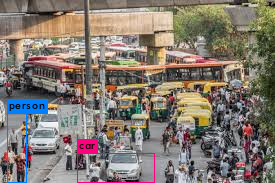
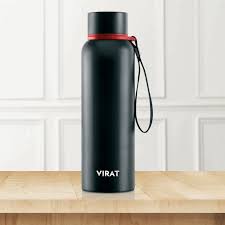
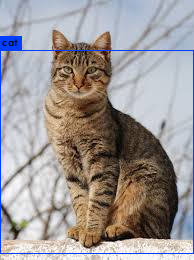
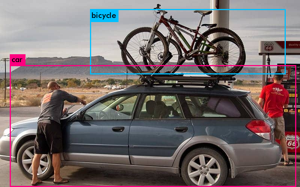
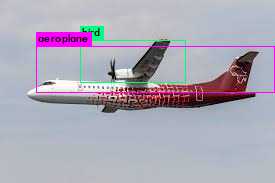


Performance Analysis:


Image,SW Time (ms),HW Time (ms),Speedup (SW/HW)
crowded.jpeg,599.30,587.62,1.02x
bottle1.jpeg,578.95,586.99,0.99x
cat.jpeg,578.10,587.20,0.98x
img1.jpg,576.02,586.97,0.98x
aeroplane.jpeg,576.49,587.05,0.98x
AVERAGE,581.77,587.17,0.99x



Detection Summary:
     IMAGE       |    TOP CLASS    |   PROB   |  SW TIME (ms)  |  HW TIME (ms) 
--------------------------------------------------------------------------------
crowded.jpeg     |       car       |  0.400   |     599.30     |     587.62    
bottle1.jpeg     |      None       |  0.000   |     578.95     |     586.99    
cat.jpeg         |       cat       |  0.940   |     578.10     |     587.20    
img1.jpg         |       car       |  0.970   |     576.02     |     586.97    
aeroplane.jpeg   |    aeroplane    |  0.560   |     576.49     |     587.05    


In [14]:
print("\nDisplaying detected objects with resized images:")
display(display_images_html(results, max_width=300, max_height=300, cols=3))

print("\nPerformance Analysis:")
display(display_performance_html(results))

print("\nDetection Summary:")
print_fancy_summary_table(results)
